In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()


process_gen_modes=["fairseq_softmax"]



do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()
compare_metric="BLEU_4"
examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['fairseq_softmax']
calculate_gen_summary_dict
get_metrics_dict


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'suite', 'instanceID', 'text', 'completion_length', 'output_logprob',
       'isCompletion', 'BLEU_1', 'BLEU_4'],
      dtype='object')
Num examples: 20000
Num completions: 200


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

df=next(iter(dfs_by_model.values()))
df["rank"]=100-df["example_idx"]



	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['fairseq_softmax'] 
 	 custom_metrics['BLEU_1', 'BLEU_4']
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name fairseq 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name            model  \
0        0.98165         1  wmt_14_language_pair_de_en_  fairseq_softmax   
1        0.98165         1  wmt_14_language_pair_de_en_  fairseq_softmax   

   example_idx    suite  instanceID             text  completion_length  \
0            0  fairseq           0  you need time .                 15   
1            1  fairseq           0  you need time .                 15   

        output_logprob isCompletion  BLEU_1  BLEU_4  
0  -0.3601841926574707         True     1.0     1.0  
1  -0.3601841926574707         None     1.0     1.0  
num examples 20000
num_completions 200
compare_metric mean:  BLEU_4    0.11675
dtype: float64


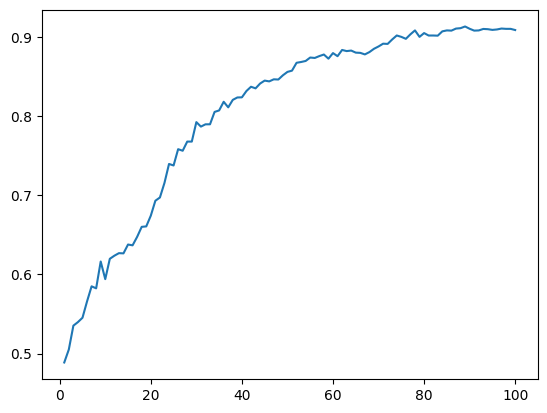

In [5]:


max_example_idx = examples_df["example_idx"].max()
plots_wide=1
num_models=len(dfs_by_model.keys())
plots_tall=math.ceil(num_models/plots_wide)

suptitle=""
axs=None
fig=None
xlabel="rank"
ylabel="example_comet"
groupby="rank"


grouped = df[[xlabel, ylabel]].groupby(groupby).mean().reset_index()
x=grouped[xlabel]
y=grouped[ylabel]

fig, ax = plt.subplots()

ax.plot(x, y)

